# Imports

In [1]:
import copy

import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib.patches import (
    BoxStyle, 
    ConnectionPatch, 
    FancyBboxPatch, 
    Rectangle
)
from pymer4.models import Lmer
from pymer4.utils import _get_params, _sig_stars
from rpy2 import robjects
from scipy.stats import chi2, gamma
from tqdm.notebook import tqdm

from khan_helpers import Experiment
from khan_helpers.constants import (
    CORRECT_ANSWER_COLOR,
    DATA_DIR,
    FIG_DIR, 
    INCORRECT_ANSWER_COLOR
)
from khan_helpers.functions import disable_logging, reconstruct_trace

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/opt/conda/lib/python3.9/site-packages/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define some helper functions

In [2]:
def lrt(*models, refit=True):
    """
    Compute a likelihood-ratio test between two (or more) `pymer4.Lmer` 
    models. Equivalent to running `anova(mod1, mod2, ...)` in R.
    
    This is a tweaked reimplementation of `pymer4.stats.lrt` that fixes 
    a bug in p-value calculations. See
    https://github.com/ejolly/pymer4/issues/134
    """
    if len(models) < 2:
        raise ValueError("Must pass at least 2 Lmer models")
    if not all(isinstance(mod, Lmer) for mod in models):
        raise TypeError("All models must by instances of pymer4.Lmer")
    
    models_list = list(models)
    show_refit_msg = False
    
    if refit:
        for i, mod in enumerate(models):
            if mod._REML:
                show_refit_msg = True
                mod_refit = copy.deepcopy(mod)
                mod_refit.fit(REML=False, summarize=False)
                models_list[i] = mod_refit
        if show_refit_msg:
            print("refitting model(s) with ML (instead of REML)")
    
    # reorder models based on number of parameters (fewest -> most)
    all_params = np.array([_get_params(m) for m in models_list])
    idx = all_params.argsort()
    all_params = all_params[idx]
    models_list = np.array(models_list)[idx]
    
    output_df = pd.DataFrame(index=range(len(models_list)), 
                             columns=('model', 'npar', 'AIC', 'BIC', 
                                      'log-likelihood', 'deviance', 'Chisq', 
                                      'Df', 'P-val', 'Sig'))
    for i, mod in enumerate(models_list):
        npar = _get_params(mod)
        if i > 0:
            df = npar - _get_params(models_list[i - 1])
            chisq = -2 * (models_list[i - 1].logLike - mod.logLike)
            pval = chi2.sf(chisq, df)
        else:
            df = np.nan
            chisq = np.nan
            pval = np.nan
        output_df.loc[i] = [mod.formula, npar, mod.AIC, mod.BIC, mod.logLike, 
                            -2 * mod.logLike, chisq, df, pval, _sig_stars(pval)]
    
    return output_df.fillna('')

In [3]:
def format_stats(odds_ratio, lrt, p_val):
    OR_fmt = f'OR = {odds_ratio:.3f}'
    lrt_fmt = f'$\lambda_{{LR}}$ = {lrt:.3f}'
    
    if p_val < 0.001:
        pval_fmt = '$p$ < 0.001'
    else:
        pval_fmt = f'$p$ = {p_val:.3f}'
        
    return f'{OR_fmt}\n{lrt_fmt}\n{pval_fmt}'

In [4]:
def annotate_textbox(
    annot_str, 
    annot_xy, 
    text_pad=0, 
    rounded=False,
    rounding_size=0.05,
    blur=False,
    blur_size=0.05,
    blur_n_steps=10,
    ax=None, 
    annot_kwargs=None,
    rect_kwargs=None
):    
    ax = ax or plt.gca()
    annot_kwargs = annot_kwargs or {}
    rect_kwargs = rect_kwargs or {}
    textbox_max_alpha = rect_kwargs.pop('alpha', 1)
    rect_kwargs.setdefault('linewidth', 0)
    rect_kwargs.setdefault('edgecolor', None)
    
    if rounded:
        RectCls = FancyBboxPatch
        annot_boxstyle = BoxStyle.Round(pad=text_pad, rounding_size=rounding_size)
    else:
        RectCls = Rectangle
        annot_boxstyle = BoxStyle.Square(pad=text_pad)
    
    # add text annotation
    annot_obj = ax.annotate(annot_str, 
                            xy=annot_xy, 
                            bbox={'boxstyle': annot_boxstyle, 
                                  'alpha': textbox_max_alpha,
                                  **rect_kwargs}, 
                            **annot_kwargs)
    
    if blur:
        # draw figure to set bbox coordinates
        ax.get_figure().canvas.draw()
        # get textbox patch object and bounding box
        annot_bbox_patch = annot_obj.get_bbox_patch()
        annot_bbox = annot_bbox_patch.get_extents().transformed(ax.transData.inverted())
        
        bbox_x0, bbox_y0, bbox_width, bbox_height = annot_bbox.bounds

        blur_pads = np.linspace(0, blur_size, blur_n_steps+1, endpoint=True)[1:]
        
        for i, pad in enumerate(blur_pads[::-1]):
            blurred_bbox = FancyBboxPatch(xy=(bbox_x0-pad, bbox_y0-pad), 
                                          width=bbox_width+(2*pad), 
                                          height=bbox_height+(2*pad),
                                          boxstyle=annot_boxstyle,
                                          alpha=textbox_max_alpha*i/(len(blur_pads)-1),
                                          transform=ax.transAxes,
                                          edgecolor=None,
                                          linewidth=0,
                                          zorder=annot_obj.get_zorder()-0.1,
                                          **rect_kwargs)
            ax.add_patch(blurred_bbox)

# Collect data for analyses

In [5]:
exp = Experiment()

CONDITIONS = ['all_questions', 'lec1_within', 'lec2_within', 'lec1_across', 'lec2_across']

In [6]:
datalist = []

pbar = tqdm(total=len(exp.all_data), leave=False)

for quiz_n in range(1, 4):
    for p in exp.participants:
        # participant ID
        subid = p.subID
        # data for questions from given quiz
        quiz_data = p.get_data(quiz=quiz_n-1)
        
        for target_question_row in quiz_data.itertuples():
            if target_question_row.qID == 38:
                pbar.update()
                continue
            
            # target question
            target_question_id = target_question_row.qID
            target_question_acc = target_question_row.accuracy
            target_question_lec = target_question_row.lecture
            target_question_vec = exp.question_vectors[target_question_id - 1]
            
            # all other questions on same quiz
            other_questions_rows = quiz_data.drop(index=target_question_row.Index)
            other_questions_acc = other_questions_rows['accuracy']
            other_questions_vecs = exp.question_vectors[other_questions_rows['qID'] - 1]
            # knowledge estimated based on all other questions on same quiz
            knowledge_estimate_all = reconstruct_trace(target_question_vec[None, :], 
                                                       other_questions_vecs, 
                                                       other_questions_acc).item()
            
            if target_question_lec == 0:
                # skip general knowledge questions for within/across estimates
                pcorrect_same = np.nan
                knowledge_estimate_same = np.nan
                pcorrect_other = np.nan
                knowledge_estimate_other = np.nan
            else:
                # questions about either of the two lectures
                lecture_related_rows = other_questions_rows.loc[
                    other_questions_rows['lecture'].isin((1, 2))
                ]
                lecture_related_vecs = exp.question_vectors[lecture_related_rows['qID'] - 1]
                lecture_related_acc = lecture_related_rows['accuracy']
                
                # questions about same lecture as target question
                same_lecture_rows = other_questions_rows.loc[
                    other_questions_rows['lecture'] == target_question_lec
                ]
                same_lecture_vecs = exp.question_vectors[same_lecture_rows['qID'] - 1]
                same_lecture_acc = same_lecture_rows['accuracy']
                pcorrect_same = same_lecture_acc.sum() / 4
                # knowledge estimate based on questions about same lecture
                knowledge_estimate_same = reconstruct_trace(target_question_vec[None, :], 
                                                            same_lecture_vecs, 
                                                            same_lecture_acc).item()
                
                # questions about opposite lecture from target question
                opp_lecture = (not target_question_lec - 1) + 1
                opp_lecture_rows = other_questions_rows.loc[
                    other_questions_rows['lecture'] == opp_lecture
                ]
                opp_lecture_vecs = exp.question_vectors[opp_lecture_rows['qID'] - 1]
                opp_lecture_acc = opp_lecture_rows['accuracy']
                pcorrect_other = opp_lecture_acc.sum() / 5
                # knowledge estimate based on questions about opposite lecture
                knowledge_estimate_other = reconstruct_trace(target_question_vec[None, :], 
                                                             opp_lecture_vecs, 
                                                             opp_lecture_acc).item()
                
            datalist.append({
                'quiz': f'Quiz{quiz_n}',
                'qID': f'Q{target_question_id}',
                'participant_id': subid,
                'lecture': target_question_lec,
                'accuracy': target_question_acc,
                'pcorrect_all': other_questions_acc.sum() / 12,
                'knowledge_all': knowledge_estimate_all,
                'pcorrect_same': pcorrect_same,
                'knowledge_same': knowledge_estimate_same, 
                'pcorrect_other': pcorrect_other,
                'knowledge_other': knowledge_estimate_other
            })
            pbar.update()    
pbar.close()

lme_data = pd.DataFrame(datalist).replace({
    'accuracy': {
        1: 'correct',
        0: 'incorrect'
    },
    'lecture': {
        1: 'Forces',
        2: 'BoS',
        0: 'general'
    }
}).astype({
    # convert to categorical dtype so variables are treated as factors in R
    'quiz': pd.CategoricalDtype(categories=('Quiz1', 'Quiz2', 'Quiz3'), ordered=True),
    'qID': 'category',
    'participant_id': 'category',
    'lecture': 'category',
    'accuracy': pd.CategoricalDtype(categories=('incorrect', 'correct'))
})

lme_data.head()

  0%|          | 0/1950 [00:00<?, ?it/s]

,quiz,qID,participant_id,lecture,accuracy,pcorrect_all,knowledge_all,pcorrect_same,knowledge_same,pcorrect_other,knowledge_other
0,Quiz1,Q13,P1,Forces,correct,0.500000,0.297975,0.50,0.007155,0.6,0.355440
1,Quiz1,Q21,P1,BoS,incorrect,0.583333,0.632423,0.75,0.507077,0.6,1.000000
2,Quiz1,Q12,P1,Forces,incorrect,0.583333,0.531722,0.75,0.525266,0.6,0.641186
3,Quiz1,Q16,P1,BoS,correct,0.500000,0.472796,0.50,0.980253,0.6,0.356176
4,Quiz1,Q28,P1,BoS,correct,0.500000,0.278380,0.50,0.010994,0.6,0.853083


In [7]:
quiz1_lme_data = lme_data.loc[lme_data['quiz'] == 'Quiz1']
quiz2_lme_data = lme_data.loc[lme_data['quiz'] == 'Quiz2']
quiz3_lme_data = lme_data.loc[lme_data['quiz'] == 'Quiz3']

In [8]:
models = {f'quiz{i}': {cond: {} for cond in CONDITIONS} for i in range(1, 4)}

# All questions

## Quiz 1

In [9]:
mod = Lmer('accuracy ~ knowledge_all + (1+knowledge_all|participant_id) + (1+knowledge_all|lecture:qID)',
           data=quiz1_lme_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|lecture:qID)',
                data=quiz1_lme_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1+knowledge_all|participant_id)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'participant_id': 50.0, 'lecture:qID': 38.0}

Log-likelihood: -384.581 	 AIC: 785.163

Random effects:

                         Name    Var    Std
participant_id    (Intercept)  1.643  1.282
participant_id  knowledge_all  6.865  2.620
lecture:qID       (Intercept)  1.419  1.191
lecture:qID     knowledge_all  2.109  1.452

                        IV1            IV2   Corr
participant_id  (Intercept)  knowledge_all -0.591
lecture:qID     (Intercept)  knowledge_all -0.228

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.404,-0.390,1.198,0.405,1.497,0.677,3.313,0.60,0.404,0.768,0.996,0.319,
knowledge_all,-1.992,-3.598,-0.386,0.819,0.136,0.027,0.679,0.12,0.027,0.405,-2.432,0.015,*




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'participant_id': 50.0, 'lecture:qID': 38.0}

Log-likelihood: -394.456 	 AIC: 794.912

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.540  0.735
lecture:qID     (Intercept)  1.411  1.188

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.335,-0.804,0.135,0.24,0.716,0.448,1.144,0.417,0.309,0.534,-1.397,0.162,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|lecture:qID),3,794.911849,808.272724,-394.455925,788.911849,,,,
1,accuracy~knowledge_all+(1+knowledge_all|partic...,8,785.162701,820.791701,-384.581351,769.162701,19.749148,5,0.001393,**


## Quiz 2

In [10]:
mod = Lmer('accuracy ~ knowledge_all + (1+knowledge_all|participant_id) + (1+knowledge_all|lecture) + (1+knowledge_all|lecture:qID)',
           data=quiz2_lme_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|lecture) + (1|lecture:qID)',
                data=quiz2_lme_data,
                family='binomial')

display(mod.fit(control='optimizer="bobyqa"'))
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1+knowledge_all|participant_id)+(1+knowledge_all|lecture)+(1+knowledge_all|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'participant_id': 50.0, 'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -349.023 	 AIC: 720.046

Random effects:

                         Name    Var    Std
participant_id    (Intercept)  0.675  0.821
participant_id  knowledge_all  5.038  2.245
lecture:qID       (Intercept)  1.031  1.015
lecture:qID     knowledge_all  1.076  1.037
lecture           (Intercept)  0.193  0.440
lecture         knowledge_all  2.385  1.544

                        IV1            IV2   Corr
participant_id  (Intercept)  knowledge_all -0.969
lecture:qID     (Intercept)  knowledge_all -0.244
lecture         (Intercept)  knowledge_all -0.008

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.036,-1.068,0.997,0.527,0.965,0.344,2.710,0.491,0.256,0.730,-0.068,0.946,
knowledge_all,1.066,-1.188,3.321,1.150,2.905,0.305,27.696,0.744,0.234,0.965,0.927,0.354,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|lecture)+(1|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 635	 Groups: {'participant_id': 50.0, 'lecture:qID': 38.0, 'lecture': 3.0}

Log-likelihood: -357.690 	 AIC: 723.379

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.546  0.739
lecture:qID     (Intercept)  1.016  1.008
lecture         (Intercept)  0.977  0.988

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.75,-0.456,1.956,0.615,2.117,0.634,7.071,0.679,0.388,0.876,1.219,0.223,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|lecture)+(1|lec...,4,723.379249,741.193749,-357.689625,715.379249,,,,
1,accuracy~knowledge_all+(1+knowledge_all|partic...,11,720.046243,769.036118,-349.023122,698.046243,17.333006,7,0.015371,*


## Quiz 3

In [11]:
mod = Lmer('accuracy ~ knowledge_all + (1|participant_id) + (1+knowledge_all||lecture:qID)',
           data=quiz3_lme_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|lecture:qID)',
                data=quiz3_lme_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['all_questions'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_all+(1|participant_id)+(1+knowledge_all||lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 630	 Groups: {'participant_id': 50.0, 'lecture:qID': 38.0}

Log-likelihood: -293.901 	 AIC: 597.801

Random effects:

                         Name    Var    Std
participant_id    (Intercept)  0.312  0.559
lecture.qID       (Intercept)  0.231  0.481
lecture.qID.1   knowledge_all  2.735  1.654

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.873,-0.367,2.114,0.633,2.395,0.693,8.281,0.705,0.409,0.892,1.380,0.168,
knowledge_all,1.175,-0.375,2.725,0.791,3.238,0.687,15.254,0.764,0.407,0.938,1.486,0.137,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 630	 Groups: {'participant_id': 50.0, 'lecture:qID': 38.0}

Log-likelihood: -297.342 	 AIC: 600.684

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.522  0.723
lecture:qID     (Intercept)  1.685  1.298

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.719,1.185,2.253,0.273,5.578,3.269,9.517,0.848,0.766,0.905,6.306,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|lecture:qID),3,600.683685,614.020845,-297.341843,594.683685,,,,
1,accuracy~knowledge_all+(1|participant_id)+(1+k...,5,597.801200,620.029799,-293.900600,587.801200,6.882485,2,0.032025,*


# Within-lecture

## Quiz 1

### Lecture 1 given lecture 1

In [12]:
quiz1_lec1_within_data = quiz1_lme_data.loc[quiz1_lme_data['lecture'] == 'Forces']

mod = Lmer('accuracy ~ knowledge_same + (1|qID)',
           data=quiz1_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz1_lec1_within_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'qID': 15.0}

Log-likelihood: -146.618 	 AIC: 299.236

Random effects:

            Name  Var    Std
qID  (Intercept)  2.0  1.414

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.807,-1.670,0.056,0.440,0.446,0.188,1.057,0.309,0.158,0.514,-1.834,0.067,.
knowledge_same,0.637,-0.194,1.468,0.424,1.891,0.824,4.341,0.654,0.452,0.813,1.502,0.133,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'qID': 15.0}

Log-likelihood: -147.737 	 AIC: 299.474

Random effects:

            Name    Var    Std
qID  (Intercept)  1.862  1.365

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.534,-1.293,0.225,0.387,0.586,0.274,1.252,0.37,0.215,0.556,-1.38,0.168,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,299.474372,306.517294,-147.737186,295.474372,,,,
1,accuracy~knowledge_same+(1|qID),3,299.235867,309.800249,-146.617933,293.235867,2.238505,1,0.134611,


### Lecture 2 given lecture 2

In [13]:
quiz1_lec2_within_data = quiz1_lme_data.loc[quiz1_lme_data['lecture'] == 'BoS']

mod = Lmer('accuracy ~ knowledge_same + (1|participant_id) + (1|qID)',
           data=quiz1_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz1_lec2_within_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -161.069 	 AIC: 330.137

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.843  0.918
qID             (Intercept)  0.561  0.749

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.478,-1.326,0.370,0.433,0.620,0.266,1.447,0.383,0.21,0.591,-1.105,0.269,
knowledge_same,-0.326,-2.194,1.542,0.953,0.722,0.112,4.673,0.419,0.10,0.824,-0.342,0.732,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -161.120 	 AIC: 328.241

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.568  0.753
qID             (Intercept)  0.544  0.737

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.589,-1.111,-0.067,0.266,0.555,0.329,0.935,0.357,0.248,0.483,-2.214,0.027,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,328.241000,338.805382,-161.120500,322.241000,,,,
1,accuracy~knowledge_same+(1|participant_id)+(1|...,4,330.137228,344.223072,-161.068614,322.137228,0.103772,1,0.747349,


## Quiz 2

### Lecture 1 given lecture 1

In [14]:
quiz2_lec1_within_data = quiz2_lme_data.loc[quiz2_lme_data['lecture'] == 'Forces']

mod = Lmer('accuracy ~ knowledge_same + (0+knowledge_same|participant_id) + (1+knowledge_same||qID)',
           data=quiz2_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz2_lec1_within_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(0+knowledge_same|participant_id)+(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -113.308 	 AIC: 236.616

Random effects:

                          Name    Var    Std
participant_id  knowledge_same  1.250  1.118
qID                (Intercept)  1.458  1.208
qID.1           knowledge_same  0.531  0.728

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.208,-0.785,1.200,0.506,1.231,0.456,3.321,0.552,0.313,0.769,0.41,0.682,
knowledge_same,2.200,0.743,3.657,0.743,9.023,2.102,38.731,0.900,0.678,0.975,2.96,0.003,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'qID': 15.0}

Log-likelihood: -122.661 	 AIC: 249.323

Random effects:

            Name    Var    Std
qID  (Intercept)  1.208  1.099

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.531,0.852,2.209,0.346,4.621,2.345,9.108,0.822,0.701,0.901,4.422,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,249.322640,256.365562,-122.661320,245.322640,,,,
1,accuracy~knowledge_same+(0+knowledge_same|part...,5,236.615588,254.222893,-113.307794,226.615588,18.707052,3,0.000314,***


### Lecture 2 given lecture 2

In [15]:
quiz2_lec2_within_data = quiz2_lme_data.loc[quiz2_lme_data['lecture'] == 'BoS']

mod = Lmer('accuracy ~ knowledge_same + (1+knowledge_same||participant_id) + (1+knowledge_same||qID)',
           data=quiz2_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz2_lec2_within_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1+knowledge_same||participant_id)+(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -158.119 	 AIC: 328.238

Random effects:

                            Name    Var    Std
participant_id       (Intercept)  0.431  0.657
participant_id.1  knowledge_same  3.139  1.772
qID                  (Intercept)  0.463  0.680
qID.1             knowledge_same  0.000  0.000

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.411,-1.154,0.331,0.379,0.663,0.315,1.393,0.399,0.240,0.582,-1.085,0.278,
knowledge_same,-1.184,-3.578,1.210,1.221,0.306,0.028,3.354,0.234,0.027,0.770,-0.969,0.332,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -160.677 	 AIC: 327.354

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.149  0.385
qID             (Intercept)  0.376  0.613

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.613,-1.047,-0.178,0.222,0.542,0.351,0.837,0.351,0.26,0.456,-2.765,0.006,**


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,327.353577,337.917959,-160.676788,321.353577,,,,
1,accuracy~knowledge_same+(1+knowledge_same||par...,6,328.238281,349.367046,-158.119140,316.238281,5.115296,3,0.163547,


## Quiz 3

### Lecture 1 given lecture 1

In [16]:
quiz3_lec1_within_data = quiz3_lme_data.loc[quiz3_lme_data['lecture'] == 'Forces']

mod = Lmer('accuracy ~ knowledge_same + (1|participant_id) + (1+knowledge_same||qID)',
           data=quiz3_lec1_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz3_lec1_within_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec1_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1|participant_id)+(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -107.679 	 AIC: 225.358

Random effects:

                          Name    Var    Std
participant_id     (Intercept)  7.921  2.814
qID                (Intercept)  1.008  1.004
qID.1           knowledge_same  7.700  2.775

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),6.281,2.634,9.927,1.861,534.107,13.925,20485.476,0.998,0.933,1.000,3.375,0.001,***
knowledge_same,-4.311,-8.204,-0.418,1.986,0.013,0.000,0.658,0.013,0.000,0.397,-2.170,0.030,*




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -115.003 	 AIC: 236.006

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.831  0.912
qID             (Intercept)  3.576  1.891

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.906,0.711,3.101,0.61,6.724,2.035,22.213,0.871,0.671,0.957,3.126,0.002,**


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,236.006191,246.570574,-115.003096,230.006191,,,,
1,accuracy~knowledge_same+(1|participant_id)+(1+...,5,225.357799,242.965104,-107.678900,215.357799,14.648392,2,0.000659,***


### Lecture 2 given lecture 2

In [17]:
quiz3_lec2_within_data = quiz3_lme_data.loc[quiz3_lme_data['lecture'] == 'BoS']

mod = Lmer('accuracy ~ knowledge_same + (1+knowledge_same||qID)',
           data=quiz3_lec2_within_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz3_lec2_within_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec2_within'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_same+(1+knowledge_same||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'qID': 15.0}

Log-likelihood: -115.074 	 AIC: 238.148

Random effects:

                 Name    Var    Std
qID       (Intercept)  0.000  0.001
qID.1  knowledge_same  1.343  1.159

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.359,-0.350,1.068,0.362,1.432,0.705,2.910,0.589,0.413,0.744,0.993,0.321,
knowledge_same,1.699,0.551,2.847,0.586,5.467,1.734,17.231,0.845,0.634,0.945,2.900,0.004,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'qID': 15.0}

Log-likelihood: -120.409 	 AIC: 244.818

Random effects:

            Name   Var    Std
qID  (Intercept)  0.67  0.819

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.571,1.016,2.127,0.283,4.813,2.761,8.388,0.828,0.734,0.893,5.543,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,244.818152,251.861074,-120.409076,240.818152,,,,
1,accuracy~knowledge_same+(1+knowledge_same||qID),4,238.148035,252.233879,-115.074018,230.148035,10.670117,2,0.00482,**


# Across-lecture

## Quiz 1

### Lecture 1 given lecture 2

In [18]:
quiz1_lec1_across_data = quiz1_lme_data.loc[quiz1_lme_data['lecture'] == 'Forces']

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1+knowledge_other|qID)',
           data=quiz1_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|lecture:qID)',
                data=quiz1_lec1_across_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -144.051 	 AIC: 300.103

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.030  0.173
qID                 (Intercept)  0.779  0.883
qID             knowledge_other  3.423  1.850

             IV1              IV2   Corr
qID  (Intercept)  knowledge_other  0.757

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.788,-1.452,-0.124,0.339,0.455,0.234,0.883,0.313,0.190,0.469,-2.326,0.020,*
knowledge_other,0.640,-0.745,2.024,0.706,1.896,0.475,7.569,0.655,0.322,0.883,0.906,0.365,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|lecture:qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'lecture:qID': 15.0}

Log-likelihood: -147.654 	 AIC: 301.307

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.102  0.319
lecture:qID     (Intercept)  1.948  1.396

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.546,-1.327,0.235,0.399,0.579,0.265,1.265,0.367,0.21,0.558,-1.371,0.171,


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|lecture:qID),3,301.307388,311.871771,-147.653694,295.307388,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,6,300.102642,321.231408,-144.051321,288.102642,7.204745,3,0.06565,.


### Lecture 2 given lecture 1

In [19]:
quiz1_lec2_across_data = quiz1_lme_data.loc[quiz1_lme_data['lecture'] == 'BoS']

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1+knowledge_other|qID)',
           data=quiz1_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz1_lec2_across_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz1']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1+knowledge_other|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -157.896 	 AIC: 327.793

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.359  0.599
qID                 (Intercept)  1.737  1.318
qID             knowledge_other  3.837  1.959

             IV1              IV2   Corr
qID  (Intercept)  knowledge_other -0.883

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.829,-1.711,0.053,0.450,0.437,0.181,1.055,0.304,0.153,0.513,-1.841,0.066,.
knowledge_other,0.420,-1.081,1.921,0.766,1.522,0.339,6.827,0.604,0.253,0.872,0.549,0.583,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -161.120 	 AIC: 328.241

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.568  0.753
qID             (Intercept)  0.544  0.737

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.589,-1.111,-0.067,0.266,0.555,0.329,0.935,0.357,0.248,0.483,-2.214,0.027,*


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,328.241000,338.805382,-161.120500,322.241000,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,6,327.792716,348.921482,-157.896358,315.792716,6.448283,3,0.091725,.


## Quiz 2

### Lecture 1 given lecture 2

In [20]:
quiz2_lec1_across_data = quiz2_lme_data.loc[quiz2_lme_data['lecture'] == 'Forces']

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1|qID)',
           data=quiz2_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz2_lec1_across_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -116.055 	 AIC: 240.111

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  1.509  1.229
qID             (Intercept)  2.012  1.418

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.461,0.343,2.580,0.571,4.312,1.409,13.201,0.812,0.585,0.930,2.560,0.010,*
knowledge_other,1.250,-0.097,2.597,0.687,3.490,0.907,13.427,0.777,0.476,0.931,1.818,0.069,.




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -117.688 	 AIC: 241.376

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  1.905  1.380
qID             (Intercept)  2.025  1.423

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),2.014,0.969,3.058,0.533,7.49,2.635,21.29,0.882,0.725,0.955,3.778,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,241.376286,251.940669,-117.688143,235.376286,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,4,240.110734,254.196578,-116.055367,232.110734,3.265552,1,0.070749,.


### Lecture 2 given lecture 1

In [21]:
quiz2_lec2_across_data = quiz2_lme_data.loc[quiz2_lme_data['lecture'] == 'BoS']

mod = Lmer('accuracy ~ knowledge_other + (1+knowledge_other||participant_id) + (1+knowledge_other||qID)',
           data=quiz2_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz2_lec2_across_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz2']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1+knowledge_other||participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -159.074 	 AIC: 330.149

Random effects:

                             Name    Var    Std
participant_id        (Intercept)  0.000  0.000
participant_id.1  knowledge_other  0.257  0.507
qID                   (Intercept)  0.134  0.366
qID.1             knowledge_other  0.354  0.595

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-1.120,-2.052,-0.189,0.475,0.326,0.128,0.828,0.246,0.114,0.453,-2.357,0.018,*
knowledge_other,0.623,-0.530,1.776,0.588,1.865,0.589,5.907,0.651,0.371,0.855,1.059,0.290,




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -160.677 	 AIC: 327.354

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.149  0.385
qID             (Intercept)  0.376  0.613

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.613,-1.047,-0.178,0.222,0.542,0.351,0.837,0.351,0.26,0.456,-2.765,0.006,**


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,327.353577,337.917959,-160.676788,321.353577,,,,
1,accuracy~knowledge_other+(1+knowledge_other||p...,6,330.148547,351.277312,-159.074273,318.148547,3.20503,3,0.361081,


## Quiz 3

### Lecture 1 given lecture 2

In [22]:
quiz3_lec1_across_data = quiz3_lme_data.loc[quiz3_lme_data['lecture'] == 'Forces']

mod = Lmer('accuracy ~ knowledge_other + (0+knowledge_other||participant_id) + (1+knowledge_other||qID)',
           data=quiz3_lec1_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|qID)',
                data=quiz3_lec1_across_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec1_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(0+knowledge_other||participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -110.873 	 AIC: 231.747

Random effects:

                           Name    Var    Std
participant_id  knowledge_other  0.475  0.689
qID                 (Intercept)  3.245  1.801
qID.1           knowledge_other  0.441  0.664

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.110,-1.642,1.421,0.781,0.895,0.194,4.142,0.472,0.162,0.806,-0.141,0.888,
knowledge_other,2.424,0.697,4.152,0.881,11.294,2.008,63.532,0.919,0.668,0.985,2.751,0.006,**




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'qID': 15.0}

Log-likelihood: -116.401 	 AIC: 236.802

Random effects:

            Name    Var    Std
qID  (Intercept)  2.473  1.573

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.641,0.727,2.554,0.466,5.158,2.07,12.854,0.838,0.674,0.928,3.521,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|qID),2,236.801625,243.844546,-116.400812,232.801625,,,,
1,accuracy~knowledge_other+(0+knowledge_other||p...,5,231.746531,249.353836,-110.873266,221.746531,11.055093,3,0.011432,*


### Lecture 2 given lecture 1

In [23]:
quiz3_lec2_across_data = quiz3_lme_data.loc[quiz3_lme_data['lecture'] == 'BoS']

mod = Lmer('accuracy ~ knowledge_other + (1|participant_id) + (1+knowledge_other||qID)',
           data=quiz3_lec2_across_data,
           family='binomial')
null_mod = Lmer('accuracy ~ (1|participant_id) + (1|qID)',
                data=quiz3_lec2_across_data,
                family='binomial')

display(mod.fit())
print(f"\n{'='*100}\n")
display(null_mod.fit())
print(f"\n{'='*100}\n")
lrt_result = lrt(mod, null_mod)
display(lrt_result)

models['quiz3']['lec2_across'] = {'mod': mod, 'null_mod': null_mod, 'lrt': lrt_result}

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~knowledge_other+(1|participant_id)+(1+knowledge_other||qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -114.493 	 AIC: 238.987

Random effects:

                           Name    Var    Std
participant_id      (Intercept)  0.665  0.815
qID                 (Intercept)  0.000  0.000
qID.1           knowledge_other  1.742  1.320

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.317,-0.990,1.623,0.667,1.372,0.371,5.071,0.578,0.271,0.835,0.475,0.635,
knowledge_other,1.988,0.246,3.730,0.889,7.302,1.279,41.680,0.880,0.561,0.977,2.237,0.025,*




Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: accuracy~(1|participant_id)+(1|qID)

Family: binomial	 Inference: parametric

Number of observations: 250	 Groups: {'participant_id': 50.0, 'qID': 15.0}

Log-likelihood: -118.028 	 AIC: 242.055

Random effects:

                       Name    Var    Std
participant_id  (Intercept)  0.943  0.971
qID             (Intercept)  0.943  0.971

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),1.865,1.087,2.644,0.397,6.458,2.965,14.063,0.866,0.748,0.934,4.697,0.0,***


,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,accuracy~(1|participant_id)+(1|qID),3,242.055428,252.619810,-118.027714,236.055428,,,,
1,accuracy~knowledge_other+(1|participant_id)+(1...,5,238.986946,256.594251,-114.493473,228.986946,7.068481,2,0.029181,*


# Run parametric bootstrap for LRT

In [24]:
N_BOOTS = 1000
LRT_BOOTS_DIR = DATA_DIR.joinpath('LRT-bootstraps')

In [25]:
# # NOTE: this takes a very long time to run in the Docker container. To 
# # reproduce this output, it may be more tractible to reconstruct the 
# # conda environment locally to take full advantage of parallelization
# pbar = tqdm(total=len(CONDITIONS) * 3, leave=False)

# for quiz_n in range(1, 4):
#     for cond in CONDITIONS:
#         boot_filepath = str(LRT_BOOTS_DIR.joinpath(f'LRT-boots-quiz{quiz_n}-{cond}.csv'))
        
#         model = models[f'quiz{quiz_n}'][cond]['mod']
#         null_model = models[f'quiz{quiz_n}'][cond]['null_mod']
        
#         robjects.globalenv['model'] = model.model_obj
#         robjects.globalenv['null_model'] = null_model.model_obj
        
#         robjects.r(
#             f"""
#             set.seed(0)
#             cl <- parallel::makeCluster(5)    # must be an even divisor of N_BOOTS
#             lrt_null_dist <- pbkrtest::PBrefdist(model, null_model, nsim = {N_BOOTS}, seed = 123, cl = cl)
#             parallel::stopCluster(cl)
#             write.csv(as.vector(lrt_null_dist), {boot_filepath}, row.names = FALSE)
#             """
#         )
#         pbar.update()
        
# pbar.close()

In [26]:
for quiz_n in range(1, 4):
    print(f'Quiz {quiz_n}:')
    
    for cond in CONDITIONS:
        print(f'\t{cond}:')
        
        lrt_observed = models[f'quiz{quiz_n}'][cond]['lrt'].loc[1, 'Chisq']
        
        boot_filepath = str(LRT_BOOTS_DIR.joinpath(f'LRT-boots-quiz{quiz_n}-{cond}.csv'))
        lrt_boots = pd.read_csv(boot_filepath).squeeze().to_numpy()
        
        # compute bootstrapped p-value and CIs for LRT statistic.
        # adapted from https://github.com/hojsgaard/pbkrtest/blob/3d22c5d/R/PB-modcomp.R
        # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC529334/
        lrt_boots_pos = lrt_boots[lrt_boots > 0]
        p_boot = ((lrt_boots_pos > lrt_observed).sum()) / len(lrt_boots_pos)
        se_p_boot = np.sqrt(p_boot * (1 - p_boot) / len(lrt_boots_pos))
        ci_p_boot = np.array([-1.96, 1.96]) * se_p_boot + p_boot
        if ci_p_boot[0] < 0:
            ci_p_boot[0] = 1e-5
        boots_mean = lrt_boots_pos.mean()
        boots_var = lrt_boots_pos.var(ddof=1)
        gamma_shape = boots_mean ** 2 / boots_var
        gamma_scale = boots_var / boots_mean
        
        ci_lr_boot = gamma.ppf(1 - ci_p_boot, a=gamma_shape, scale=gamma_scale)
        
        print(f'\t\tLR = {lrt_observed:.5f}, '
              f'95% CI = ({ci_lr_boot[1]:.5f}, {ci_lr_boot[0]:.5f}), '
              f'p = {p_boot:.5f}')
        
        models[f'quiz{quiz_n}'][cond]['p_boot'] = p_boot

Quiz 1:
	all_questions:
		LR = 19.74915, 95% CI = (inf, inf), p = 0.00000
	lec1_within:
		LR = 2.23851, 95% CI = (2.10031, 2.63429), p = 0.13828
	lec2_within:
		LR = 0.10377, 95% CI = (0.09417, 0.14601), p = 0.73795
	lec1_across:
		LR = 7.20475, 95% CI = (6.26925, 7.58649), p = 0.03804
	lec2_across:
		LR = 6.44828, 95% CI = (5.69573, 6.89832), p = 0.04158
Quiz 2:
	all_questions:
		LR = 17.33301, 95% CI = (16.08195, 29.30914), p = 0.00115
	lec1_within:
		LR = 18.70705, 95% CI = (inf, inf), p = 0.00000
	lec2_within:
		LR = 5.11530, 95% CI = (4.65424, 5.69593), p = 0.05381
	lec1_across:
		LR = 3.26555, 95% CI = (3.05119, 3.89063), p = 0.09265
	lec2_across:
		LR = 3.20503, 95% CI = (3.03799, 3.61316), p = 0.12412
Quiz 3:
	all_questions:
		LR = 6.88249, 95% CI = (6.32214, 8.35265), p = 0.01626
	lec1_within:
		LR = 14.64839, 95% CI = (inf, inf), p = 0.00000
	lec2_within:
		LR = 10.67012, 95% CI = (8.28387, 13.90808), p = 0.00511
	lec1_across:
		LR = 11.05509, 95% CI = (9.56172, 22.98268), p 

# Plot results for each condition

In [27]:
# use ggeffects::ggpredict to compute predicted probabilities of 
# answering question correctly (+ CIs) given estimated knowledge, over 
# range of possible knowledge estimates
r_cmd = 'data.frame(ggeffects::ggpredict(model, terms = "{fe_name} [0:1 by=0.01]", ci.lvl = 0.95))'

pbar = tqdm(total=len(CONDITIONS) * 3, leave=False)

for quiz_n in range(1, 4):
    for cond in CONDITIONS:
        model = models[f'quiz{quiz_n}'][cond]['mod']
        # knowledge_[all|other|same], depending on model
        knowledge_fe_name = model.coefs.index[1]
        # insert rpy2 model object into R .GlobalEnv
        robjects.globalenv['model'] = model.model_obj
        # get predicted probabilities & CIs
        r_result = robjects.r(r_cmd.format(fe_name=knowledge_fe_name))
        # convert R data.frame to pandas DataFrame
        predicted_probs = robjects.pandas2ri.rpy2py_dataframe(r_result)
        models[f'quiz{quiz_n}'][cond]['predicted_probs'] = predicted_probs
        pbar.update()
        
pbar.close()

  0%|          | 0/15 [00:00<?, ?it/s]

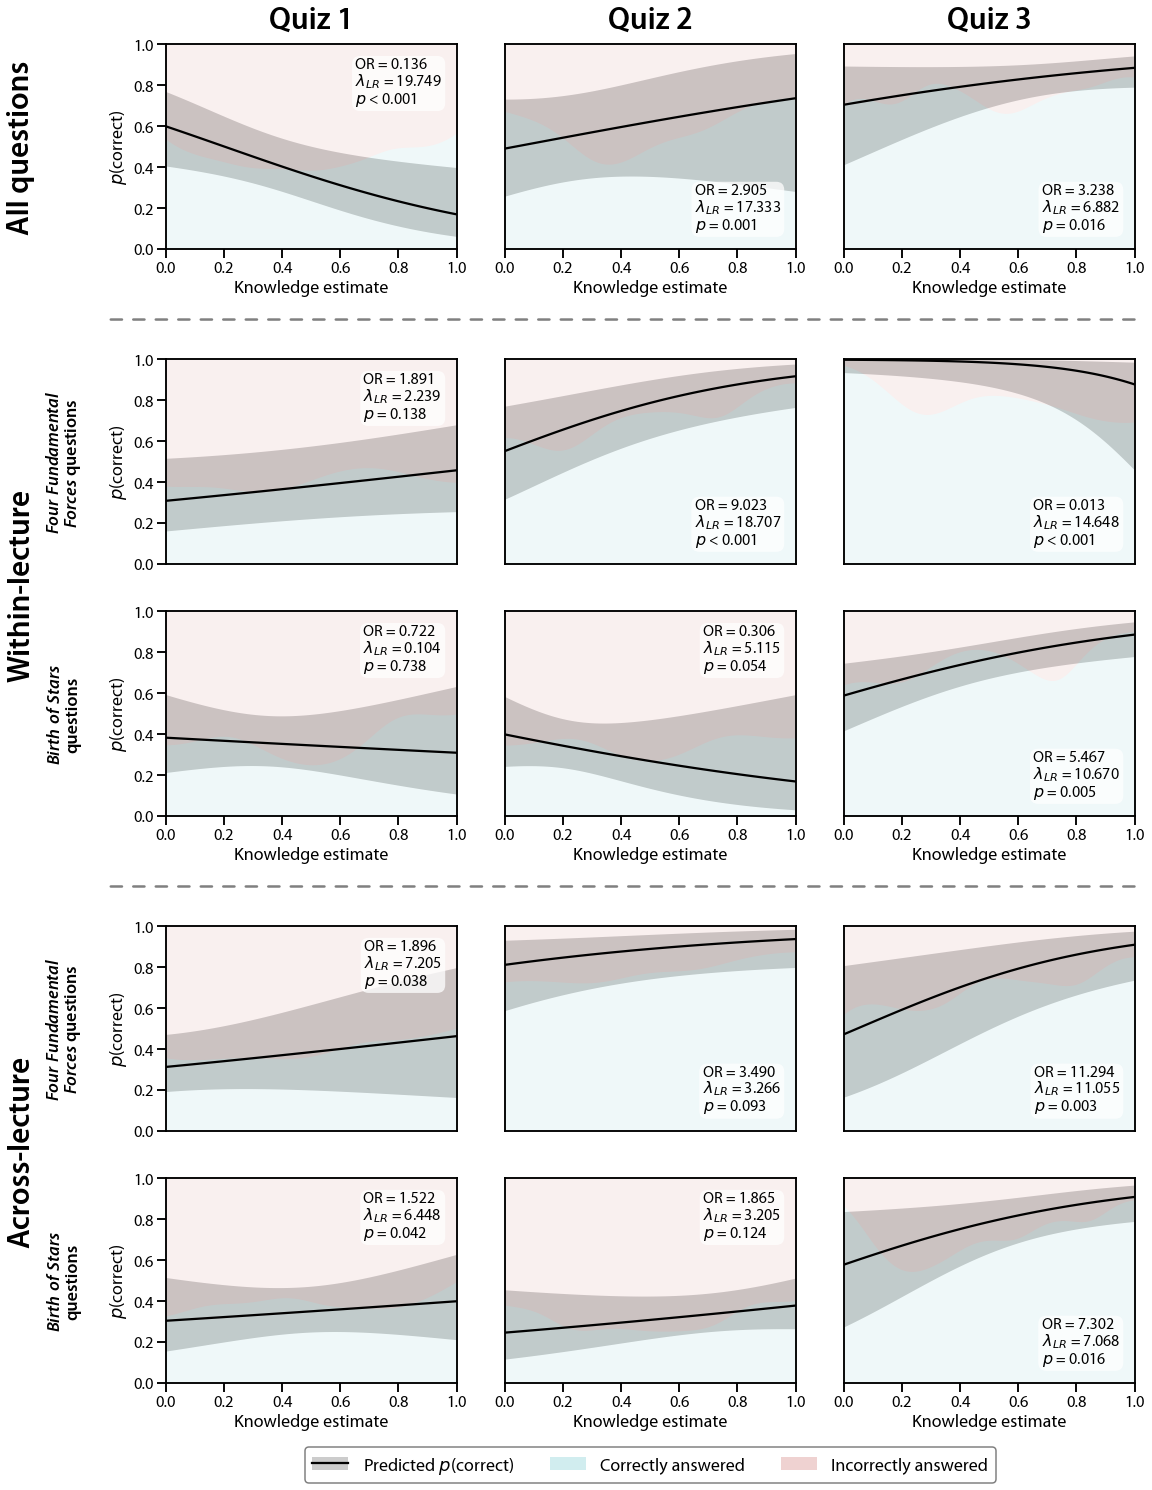

In [28]:
PREDICTION_CURVES_COLOR = 'k'          # color for predicted probability curves
PREDICTION_CIS_ALPHA = 0.2             # opacity for confidence intervals
BG_DENSITY_ALPHA = 0.1                 # opacity for background density plot

STATS_BOX_ALPHA = 0.75                 # opacity for stats annotation bounding box
STATS_BOX_PAD = 0.2                    # padding between stats text and bounding box edge
STATS_BOX_LOCS = {                     # placement options for stats annotation
    'lower right': (0.95, 0.075),
    'upper right': (0.95, 0.69)
}
STATS_UR_AXES = [                      # panels with stats boxes in upper right instead of lower right
    ('quiz1', 'all_questions'), 
    ('quiz1', 'lec1_across'),
    ('quiz1', 'lec2_across'),
    ('quiz1', 'lec1_within'),
    ('quiz1', 'lec2_within'),
    ('quiz2', 'lec2_across'),
    ('quiz2', 'lec2_within'),
]

LEGEND_AXES_HEIGHT_RATIO = 0.2         # height of legend axes relative to subplots
LEGEND_DENSITY_HANDLE_ALPHA = 0.3      # opacity for handles for background density plots

SEPLINE_AXES_HEIGHT_RATIO = 0.075      # height of separator line axes relative to subplots
SEPLINE_YAXIS_FRAC = -0.5              # vertical offset of separator line as a fraction of y-axis height
SEPLINE_PATCH_KWARGS = {               # common kwargs for horizontal separator lines
    'xyA': (-0.19, SEPLINE_YAXIS_FRAC), 
    'xyB': (1, SEPLINE_YAXIS_FRAC), 
    'coordsA': 'axes fraction', 
    'coordsB': 'axes fraction',
    'linestyle': (0, (4.5, 4.5)),
    'linewidth': 2.5,
    'color': 'grey'
}

CONDITION_YLABEL_KWARGS = {            # common kwargs for vertical condition labels
    'x': -0.45,
    'fontsize': 'xx-large',
    'fontweight': 'semibold',
    'rotation': 90,
    'horizontalalignment': 'right',
    'verticalalignment': 'center'
}
LECTURE_YLABEL_KWARGS = {              # common kwargs for vertical lecture labels
    'x': -0.35,
    'y': 0.5,
    'fontsize': 'medium',
    'fontweight': 'semibold',
    'linespacing': 1,
    'rotation': 90,
    'horizontalalignment': 'center',
    'verticalalignment': 'center'
}


with sns.plotting_context('talk'):
    
    # ======================= set up axes layout =======================
    
    fig = plt.figure(figsize=(15, 21), tight_layout={'h_pad': 0})
    gs = fig.add_gridspec(8, 3, height_ratios=(
        1, 
        SEPLINE_AXES_HEIGHT_RATIO, 
        1, 
        1, 
        SEPLINE_AXES_HEIGHT_RATIO, 
        1, 
        1, 
        LEGEND_AXES_HEIGHT_RATIO
    ))
    
    axes_dict = {
        f'quiz{quiz_n}': {
            cond: fig.add_subplot(gs[row_ix, quiz_n - 1]) 
            for (cond, row_ix) in zip(CONDITIONS, (0, 2, 3, 5, 6)) 
        } 
        for quiz_n in range(1, 4)
    }

    # set reference axes (top left subplot) for controlling all 
    # subplots' x- and y-axes range, styling, etc.
    reference_ax = fig.axes[0]
    for ax in fig.axes[1:]:
        ax.sharex(reference_ax)
        ax.sharey(reference_ax)
        
    reference_ax.set_xlim(0, 1)
    reference_ax.set_ylim(0, 1)
        
    # add axes for separator lines & legend
    sep1_axes = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 2])]
    sep2_axes = [fig.add_subplot(gs[4, 0]), fig.add_subplot(gs[4, 2])]
    legend_ax = fig.add_subplot(gs[7, :])
    
    # ================= plot observations & model fits =================
    
    for quiz_n in range(1, 4):
        quiz_key = f'quiz{quiz_n}'
        for cond in CONDITIONS:
            ax = axes_dict[quiz_key][cond]
            model = models[quiz_key][cond]['mod']
            predictions_df = models[quiz_key][cond]['predicted_probs']

            # plot predicted probability curve
            ax.plot(predictions_df['x'], 
                    predictions_df['predicted'], 
                    color=PREDICTION_CURVES_COLOR)
            ax.fill_between(x=predictions_df['x'], 
                            y1=predictions_df['conf.low'], 
                            y2=predictions_df['conf.high'],
                            color=PREDICTION_CURVES_COLOR,
                            edgecolor=None,
                            alpha=PREDICTION_CIS_ALPHA)
            
            sns.kdeplot(x=model.coefs.index[1], 
                        data=model.data, 
                        hue='accuracy', 
                        hue_order=('incorrect', 'correct'), 
                        palette=(INCORRECT_ANSWER_COLOR, CORRECT_ANSWER_COLOR),
                        multiple='fill', 
                        alpha=BG_DENSITY_ALPHA, 
                        edgecolor=None, 
                        legend=False,
                        ax=ax)
            
    # ====================== add stats annotation ======================
        
            odds_ratio = np.exp(model.coefs['Estimate'][1])
            lrt_result = models[quiz_key][cond]['lrt'].loc[1, 'Chisq']
            p_val = models[quiz_key][cond]['p_boot']
            
            stats_str = format_stats(odds_ratio, lrt_result, p_val)
            if (quiz_key, cond) in STATS_UR_AXES:
                annot_xy = STATS_BOX_LOCS['upper right']
            else:
                annot_xy = STATS_BOX_LOCS['lower right']
            annotate_textbox(stats_str, 
                             annot_xy=annot_xy, 
                             text_pad=STATS_BOX_PAD,
                             rounded=True,
                             rounding_size=0.5,
                             blur=False,
                             blur_size=0.05,
                             blur_n_steps=10,
                             ax=ax,
                             annot_kwargs={'fontsize': 16, 
                                           'linespacing': 1,
                                           'horizontalalignment': 'right', 
                                           'verticalalignment': 'bottom', 
                                           'multialignment': 'left'},
                             rect_kwargs={'facecolor': 'white', 
                                          'alpha': STATS_BOX_ALPHA})
            
    # ====================== add separator lines =======================
    
    fig.add_artist(ConnectionPatch(axesA=sep1_axes[0], 
                                   axesB=sep1_axes[1], 
                                   **SEPLINE_PATCH_KWARGS))
    fig.add_artist(ConnectionPatch(axesA=sep2_axes[0], 
                                   axesB=sep2_axes[1], 
                                   **SEPLINE_PATCH_KWARGS))
    for ax in sep1_axes + sep2_axes:
        ax.axis('off')
        
    # ======================= add shared legend ========================
    
    pred_errband, correct_bg, incorrect_bg = reference_ax.collections
    pred_line2d = reference_ax.lines[0]
    
    leg = legend_ax.legend(handles=((pred_line2d, pred_errband), 
                                    correct_bg, 
                                    incorrect_bg),
                     labels=('Predicted $p$(correct)', 
                             'Correctly answered', 
                             'Incorrectly answered'),
                     loc='lower center',
                     ncol=3,
                     fontsize='medium',
                     edgecolor='grey',
                     framealpha=1,
                     bbox_to_anchor=(0.5, -0.5))
    correct_handle, incorrect_handle = leg.legendHandles[1:]
    correct_handle.set_facecolor((*correct_handle.get_facecolor()[:3], 
                                  LEGEND_DENSITY_HANDLE_ALPHA))
    incorrect_handle.set_facecolor((*incorrect_handle.get_facecolor()[:3], 
                                    LEGEND_DENSITY_HANDLE_ALPHA))

    legend_ax.axis('off')
    
    # ==================== format axes, add labels =====================
        
    for quiz_n in range(1, 4):
        for cond in CONDITIONS:
            ax = axes_dict[f'quiz{quiz_n}'][cond]
            
            if cond.startswith('lec1'):
                ax.xaxis.set_visible(False)
                ax.tick_params(bottom=False, labelbottom=False)
            else:
                ax.set_xlabel('Knowledge estimate')
            
            if quiz_n == 1:
                ax.set_ylabel('$p$(correct)')
            else:
                ax.yaxis.set_visible(False)
                ax.tick_params(left=False, labelleft=False)
            
            if cond == 'all_questions':
                ax.set_title(f'Quiz {quiz_n}', 
                             y=1.05, 
                             fontsize='xx-large', 
                             fontweight='semibold')
                
    fig.text(y=0.5,
             s='All questions',
             transform=axes_dict['quiz1']['all_questions'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    fig.text(y=-0.1,
             s='Within-lecture',
             transform=axes_dict['quiz1']['lec1_within'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    fig.text(y=-0.1,
             s='Across-lecture',
             transform=axes_dict['quiz1']['lec1_across'].transAxes, 
             **CONDITION_YLABEL_KWARGS)
    
    with (
        disable_logging('matplotlib.font_manager', 'ERROR'), 
        plt.rc_context({
            'mathtext.fontset': 'custom', 
            'mathtext.it': 'sans:semibold:italic'
        })
    ):
        fig.text(s='$\\mathit{{Four\ Fundamental}}$\n$\\mathit{{Forces}}$ questions',
                 transform=axes_dict['quiz1']['lec1_across'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Birth\ of\ Stars}}$\nquestions',
                 transform=axes_dict['quiz1']['lec2_across'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Four\ Fundamental}}$\n$\\mathit{{Forces}}$ questions',
                 transform=axes_dict['quiz1']['lec1_within'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        fig.text(s='$\\mathit{{Birth\ of\ Stars}}$\nquestions',
                 transform=axes_dict['quiz1']['lec2_within'].transAxes, 
                 **LECTURE_YLABEL_KWARGS)
        
#         plt.savefig(FIG_DIR.joinpath('predict-knowledge-questions.pdf'), 
#                     bbox_inches='tight',
#                     dpi=300)
        plt.show()